In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_XCRD
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [7]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_XCRD
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =2.22e-20

nband = 165

ng =4

ng_refs = (/ 2 , 2 /) 

nref =2

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 500 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 1215

data w_diffuse
     &     /1.8 , 1.66 , 1.5 , 1.8/

data wgt
     &     /0.6 , 0.6 , 0.7 , 0.9/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

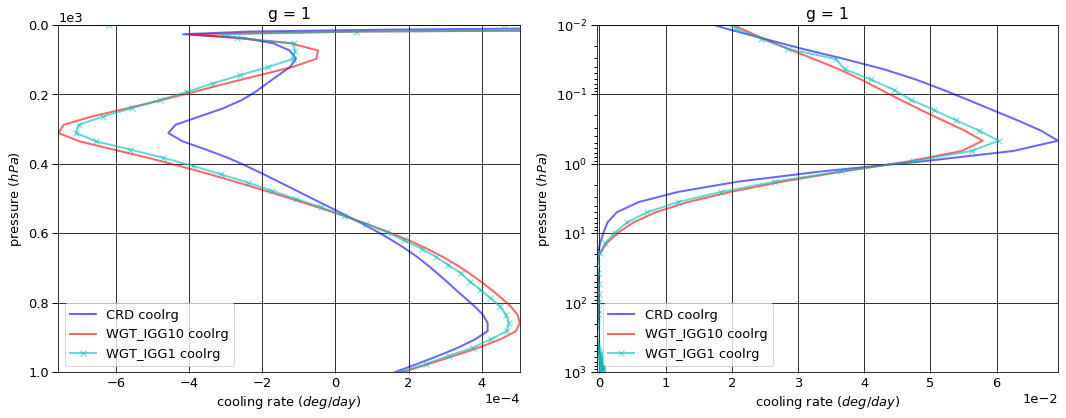

# Figure: cooling rate g-group 2

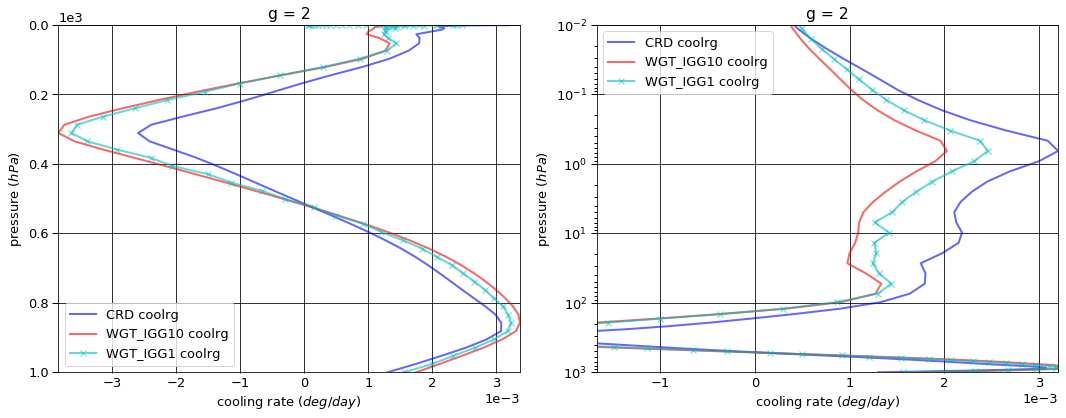

# Figure: cooling rate g-group 3

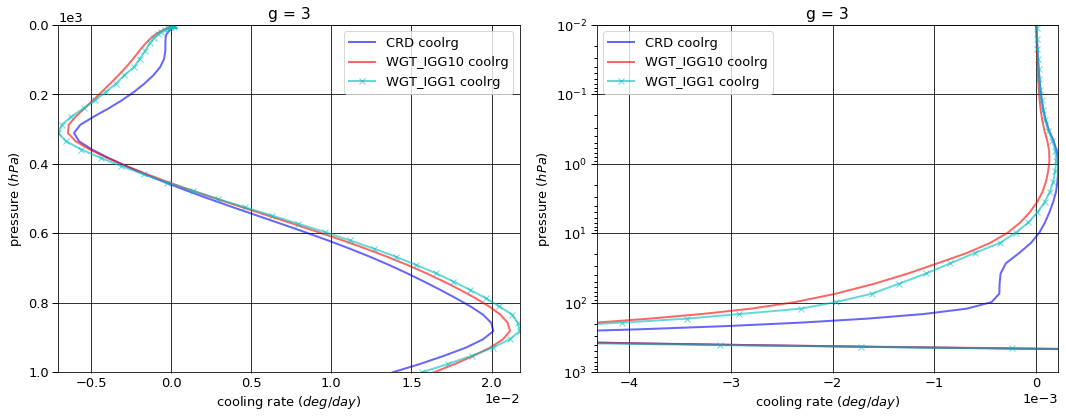

# Figure: cooling rate g-group 4

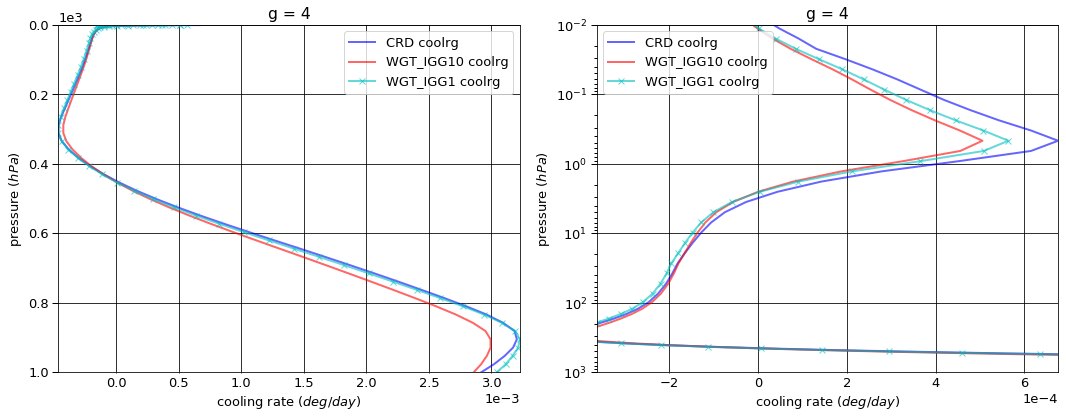

# Figure: cooling rate g-group total

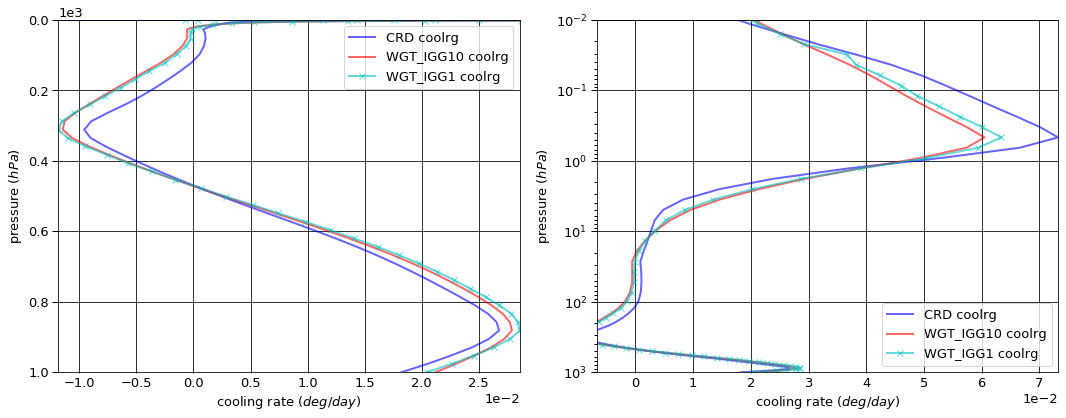

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.028036  0.000000 -0.028036
  1013.0   76    -0.055119  0.041447 -0.013672
2 0.0      1     -0.199188  0.000000 -0.199188
  1013.0   76    -0.394768  0.281322 -0.113446
3 0.0      1     -2.251632  0.000000 -2.251632
  1013.0   76    -2.859728  1.318564 -1.541165
4 0.0      1     -6.199553  0.000000 -6.199553
  1013.0   76    -6.248416  0.164310 -6.084106


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019807  0.000000 -0.019807
  1013.0   76    -0.055119  0.050412 -0.004706
2 0.0      1     -0.134833  0.000000 -0.134833
  1013.0   76    -0.394768  0.313991 -0.080777
3 0.0      1     -2.258694  0.000000 -2.258694
  1013.0   76    -2.859728  1.330712 -1.529016
4 0.0      1     -6.205542  0.000000 -6.205542
  1013.0   76    -6.248416  0.148746 -6.099670


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.019987  0.000000 -0.019987
  1013.0   76    -0.055119  0.048419 -0.006700
2 0.0      1     -0.143392  0.000000 -0.143392
  1013.0   76    -0.394768  0.305899 -0.088869
3 0.0      1     -2.183146  0.000000 -2.183146
  1013.0   76    -2.859728  1.425568 -1.434160
4 0.0      1     -6.201338  0.000000 -6.201338
  1013.0   76    -6.248416  0.161310 -6.087105


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.008229  0.000000  0.008229
  1013.0   76     0.000000  0.008965  0.008965
2 0.0      1      0.064355  0.000000  0.064355
  1013.0   76     0.000000  0.032669  0.032669
3 0.0      1     -0.007062  0.000000 -0.007062
  1013.0   76     0.000000  0.012148  0.012148
4 0.0      1     -0.005989  0.000000 -0.005989
  1013.0   76     0.000000 -0.015564 -0.015564


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.008049  0.000000  0.008049
  1013.0   76     0.000000  0.006972  0.006972
2 0.0      1      0.055796  0.000000  0.055796
  1013.0   76     0.000000  0.024577  0.024577
3 0.0      1      0.068486  0.000000  0.068486
  1013.0   76     0.000000  0.107004  0.107004
4 0.0      1     -0.001785  0.000000 -0.001785
  1013.0   76     0.000000 -0.002999 -0.002999

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.013948
  1001.112500 75     0.000162
2 0.000312    1     -0.000136
  1001.112500 75     0.001300
3 0.000312    1     -0.000004
  1001.112500 75     0.013832
4 0.000312    1     -0.000133
  1001.112500 75     0.002919


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1      0.001999
  1001.112500 75     0.000182
2 0.000312    1      0.000036
  1001.112500 75     0.001746
3 0.000312    1     -0.000003
  1001.112500 75     0.016406
4 0.000312    1     -0.000145
  1001.112500 75     0.002859


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.000621
  1001.112500 75     0.000177
2 0.000312    1      0.000054
  1001.112500 75     0.001561
3 0.000312    1     -0.000003
  1001.112500 75     0.015657
4 0.000312    1     -0.000158
  1001.112500 75     0.003043


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.594625e-02
  1001.112500 75     1.981440e-05
2 0.000312    1      1.711544e-04
  1001.112500 75     4.465272e-04
3 0.000312    1      9.494850e-08
  1001.112500 75     2.573639e-03
4 0.000312    1     -1.215126e-05
  1001.112500 75    -6.004000e-05


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      1.332643e-02
  1001.112500 75     1.474702e-05
2 0.000312    1      1.891365e-04
  1001.112500 75     2.613293e-04
3 0.000312    1      4.822894e-07
  1001.112500 75     1.825319e-03
4 0.000312    1     -2.482380e-05
  1001.112500 75     1.241464e-04

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.67841,0.000000,-8.678410
1013.0,76,-9.55803,1.805642,-7.752388



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.618876,0.000000,-8.618876
1013.0,76,-9.558030,1.843861,-7.714169



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-8.547863,0.000000,-8.547863
1013.0,76,-9.558030,1.941196,-7.616835



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.059534,0.000000,0.059534
1013.0,76,0.000000,0.038219,0.038219



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.130546,0.000000,0.130546
1013.0,76,0.000000,0.135554,0.135554


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.014220
1001.112500,75,0.018212



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.001886
1001.112500,75,0.021192



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000728
1001.112500,75,0.020438



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.016105
1001.112500,75,0.002980



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.013491
1001.112500,75,0.002226


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.005636,0.005770
2,0.040000,0.041342
3,0.290182,0.299459
4,0.664182,0.653430


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.539967e-19
2,5.006638e-21
3,2.220810e-20
4,2.164750e-26


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.539967e-19,NaN,0.005636,0.005770,0.005636,0.005770,1.0
2,5.006638e-21,9.037306e-03,0.040000,0.041342,0.045636,0.047111,1.0
3,2.220810e-20,4.435731e+00,0.290182,0.299459,0.335818,0.346570,500.0
4,2.164750e-26,9.747570e-07,0.664182,0.653430,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog         ratio        taulyr
layer g pressure                                                           
1     1 0.000312     9.195823e-18  8.105486e-19     11.345184  2.475340e-05
      2 0.000312     1.841740e-20  2.238418e-21      8.227864  5.061861e-08
      3 0.000312     3.809033e-23  3.711715e-23      1.026219  1.601651e-10
      4 0.000312     4.346220e-22  4.678296e-27  92901.771000  1.657484e-09
2     1 0.000750     9.199863e-18  8.218812e-19     11.193665  9.982216e-06
      2 0.000750     1.871673e-20  2.276928e-21      8.220169  2.072132e-08
      3 0.000750     3.962543e-23  3.860330e-23      1.026478  6.710734e-11
      4 0.000750     4.404303e-22  6.221401e-27  70792.781000  6.765349e-10
3     1 0.001052     9.208081e-18  8.449626e-19     10.897620  1.403282e-05
      2 0.001052     1.933636e-20  2.339620e-21      8.264744  3.000916e-08
      3 0.001052     4.260168e-23  4.147394e-23      1.027192  1.011583e-10
      4 0.001052     4.529407e-22  7.072017e-27  64046.900000  9.757127e-10
4     1 0.001476     9.216421e-18  8.688186e-19     10.607993  1.973537e-05
      2 0.001476     2.000809e-20  2.406197e-21      8.315235  4.354238e-08
      3 0.001476     4.590470e-23  4.465743e-23      1.027930  1.528847e-10
      4 0.001476     4.667357e-22  7.997074e-27  58363.304000  1.410509e-09
5     1 0.002070     9.224764e-18  8.931583e-19     10.328253  2.775000e-05
      2 0.002070     2.072763e-20  2.477019e-21      8.367973  6.323868e-08
      3 0.002070     4.954550e-23  4.816406e-23      1.028682  2.313916e-10
      4 0.002070     4.817378e-22  8.979647e-27  53647.749000  2.041952e-09
6     1 0.002904     9.233091e-18  9.179819e-19     10.058032  3.902458e-05
      2 0.002904     2.149865e-20  2.553677e-21      8.418705  9.196608e-08
      3 0.002904     5.358127e-23  5.204867e-23      1.029446  3.509442e-10
      4 0.002904     4.980243e-22  1.000431e-26  49780.984000  2.961159e-09
7     1 0.004074     9.239497e-18  9.431905e-19      9.796003  5.487172e-05
      2 0.004074     2.232098e-20  2.638163e-21      8.460801  1.338932e-07
      3 0.004074     5.807366e-23  5.637077e-23      1.030209  5.334543e-10
      4 0.004074     5.155707e-22  1.106763e-26  46583.676000  4.300185e-09
8     1 0.005714     9.241852e-18  9.686737e-19      9.540727  7.711834e-05
      2 0.005714     2.319426e-20  2.733137e-21      8.486316  1.951144e-07
      3 0.005714     6.310156e-23  6.120686e-23      1.030956  8.128760e-10
      4 0.005714     5.343321e-22  1.217661e-26  43881.845000  6.251279e-09
9     1 0.008015     9.244063e-18  9.946753e-19      9.293549  1.083889e-04
      2 0.008015     2.413410e-20  2.842622e-21      8.490082  2.847705e-07
      3 0.008015     6.881233e-23  6.669895e-23      1.031685  1.243167e-09
      4 0.008015     5.546051e-22  1.334027e-26  41573.766000  9.101456e-09
10    1 0.011243     9.246091e-18  1.021250e-18      9.053700  1.523395e-04
      2 0.011243     2.514892e-20  2.971348e-21      8.463809  4.163367e-07
      3 0.011243     7.537356e-23  7.300956e-23      1.032379  1.909677e-09
      4 0.011243     5.764835e-22  1.455989e-26  39593.949000  1.327019e-08
11    1 0.015771     9.247883e-18  1.048476e-18      8.820309  2.141184e-04
      2 0.015771     2.624949e-20  3.125192e-21      8.399322  6.099014e-07
      3 0.015771     8.301027e-23  8.035751e-23      1.033012  2.949610e-09
      4 0.015771     6.000621e-22  1.583150e-26  37903.053000  1.937566e-08
12    1 0.022122     9.249369e-18  1.076471e-18      8.592308  3.009542e-04
      2 0.022122     2.744997e-20  3.311324e-21      8.289728  8.955093e-07
      3 0.022122     9.202866e-23  8.904114e-23      1.033552  4.586240e-09
      4 0.022122     6.254401e-22  1.715015e-26  36468.485000  2.832785e-08
13    1 0.031031     9.250449e-18  1.105288e-18      8.369265  4.230119e-04
      2 0.031031     2.876424e-20  3.538153e-21      8.129731  1.318213e-06
      3 0.031031     1.028191e-22  9.944264e-23      1.033954  7.186658e-0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
